In [2]:
## basic packages
import pandas as pd
import numpy as np

In [335]:
## import data
path = "/content/drive/MyDrive/Datathon/"
trainings = pd.read_csv(path + "trainings.csv")

In [ ]:
trainings.head()

In [ ]:
trainings.describe()

In [336]:
# get indices of train & test data points
train_ids = trainings["type"].notnull()
test_ids = trainings["type"].isnull()

<Axes: >

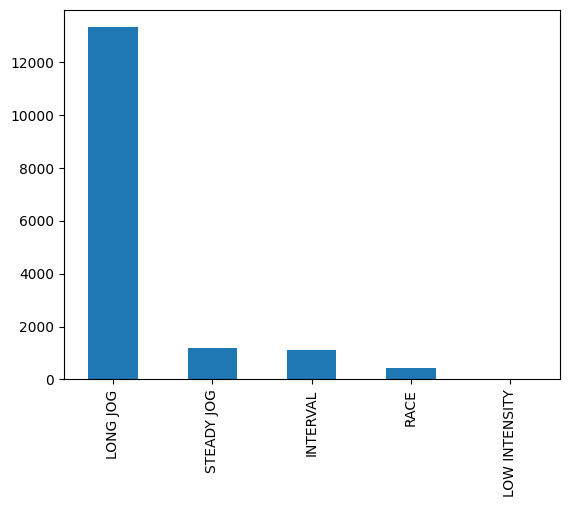

In [15]:
trainings["type"].value_counts().plot(kind="bar")

## **Data Preprocessing**

In [337]:
# encode labels as dummy
trainings["Type_RACE"] = 1*(trainings["type"]=="RACE")
trainings["Type_INTERVAL"] = 1*(trainings["type"]=="INTERVAL")
trainings["Type_LONG_JOG"] = 1*(trainings["type"]=="LONG JOG")
trainings["Type_STEADY_JOG"] = 1*(trainings["type"]=="STEADY JOG")
trainings["Type_LOW_INTENSITY"] = 1*(trainings["type"]=="LOW INTENSITY")

trainings.drop(["type"], axis=1, inplace=True)

## detect outliers

Set indicator if NA

In [338]:
vars_w_NAs = ["distance", "uphill", "downhill", "duration", "avg_hr", "power"]
for var in vars_w_NAs:
  trainings[var+"_NA"] = 1*(trainings[var].isnull())

Mark unreasonable values as NA and set indicator

In [339]:
# Duration < 10 sec
trainings["duration_<10"] = 1*(trainings["duration"] < 30)
trainings.loc[trainings["duration"] < 10, "duration"] = np.nan

# AvgHR < 30 bpm
trainings["avg_hr_<30"] = 1*(trainings["avg_hr"] < 30)
trainings.loc[trainings["avg_hr"] < 30, "avg_hr"] = np.nan

# MaxHr < 30bmp
trainings["max_hr_<30"] = 1*(trainings["max_hr"] < 30)
trainings.loc[trainings["max_hr"] < 30, "max_hr"] = np.nan

# Power < 10 W
trainings["power_<10"] = 1*(trainings["power"] < 30)
trainings.loc[trainings["power"] < 10, "power"] = np.nan

# AvgHR > MaxHR
trainings["avgHR>maxHR"] = 1*(trainings["avg_hr"] > trainings["max_hr"])
trainings.loc[trainings["avg_hr"] > trainings["max_hr"], "avg_hr"] = np.nan

In [340]:
# drop power (too many NAs)
trainings.drop(["power"], axis=1, inplace=True)

Set indicator for extreme but possbile values

In [341]:
# MaxHR > 220
trainings["max_hr_>220"] = 1*(trainings["max_hr"] > 220)

# AvgHr > 220
trainings["avg_hr_>220"] = 1*(trainings["avg_hr"] > 220)

## impute NAs

In [75]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [342]:
imputer = IterativeImputer(max_iter=10, initial_strategy="mean")
estimator = RandomForestRegressor(n_estimators=500, max_features=0.5)

cat = ["user_id", "training_id", "start_date"]
num = [var for var in trainings.columns if var not in cat]

trainings = pd.concat(
    [trainings[cat], pd.DataFrame(imputer.fit_transform(trainings.drop(cat, axis=1)), columns=num)],
                                                   axis=1)

Split train & test data

## **Baseline Models**

## Set up hyperparameter optimization

In [16]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [17]:
metric = "accuracy"

## fit models

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score

Prepare data

In [343]:
trainings["type"] = np.nan
trainings.loc[trainings["Type_RACE"]==1, "type"] = "RACE"
trainings.loc[trainings["Type_INTERVAL"]==1, "type"] = "INTERVAL"
trainings.loc[trainings["Type_LONG_JOG"]==1, "type"] = "LONG JOG"
trainings.loc[trainings["Type_STEADY_JOG"]==1, "type"] = "STEADY JOG"
trainings.loc[trainings["Type_LOW_INTENSITY"]==1, "type"] = "LOW INTENSITY"

trainings.drop(["training_id", "user_id", "start_date", "Type_RACE", "Type_INTERVAL", "Type_LONG_JOG", "Type_STEADY_JOG", "Type_LOW_INTENSITY"], axis=1, inplace=True)

## Standardize data

In [62]:
from sklearn.preprocessing import StandardScaler

In [344]:
scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(trainings.drop(["type"], axis=1)),
    columns = trainings.drop(["type"], axis=1).columns,
    index = trainings.drop(["type"], axis=1).index)

Train/Test split

In [345]:
X_train = trainings.loc[train_ids,:].drop(["type"], axis=1)
X_test = trainings.loc[test_ids,].drop(["type"], axis=1)
y_train = trainings.loc[train_ids, "type"]

In [22]:
from sklearn.model_selection import train_test_split

**K Nearest Neighbors**

In [206]:
from sklearn.neighbors import KNeighborsClassifier

In [207]:
knn = KNeighborsClassifier()
knn_params = {"n_neighbors": [1, 5, 10, 30],
              "weights": ["uniform", "distance"]}

search = HalvingRandomSearchCV(knn, scoring=metric,
                               param_distributions=knn_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)
y_pred = search.predict(X=X_test)
score = accuracy_score(y_test, y_pred)
print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 5
min_resources_: 50
max_resources_: 11271
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 50
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=225. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 3
n_resources: 150
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Opt. Params.: {'weights': 'distance', 'n_neighbors': 10}

F1 (Macro): 0.83


array([[   0,  337,    0,    0,    1],
       [   5, 3984,    0,    1,    4],
       [   0,   10,    0,    0,    0],
       [   1,  128,    0,    1,    0],
       [   0,  358,    0,    0,    1]])

**Logistic Regression**

In [37]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

In [38]:
logreg = LogisticRegressionCV(cv=5, solver="lbfgs", max_iter=3000)
logreg.fit(X=X_train, y=y_train.values.ravel())

y_pred = logreg.predict(X=X_test)
score = accuracy_score(y_test, y_pred)

print("Accuracy:", round(score, 2))
confusion_matrix(y_test, y_pred)

F1 (Macro): 0.83


array([[   0,  336,    0,    0,    2],
       [   2, 3983,    0,    9,    0],
       [   0,   10,    0,    0,    0],
       [   0,  103,    0,   27,    0],
       [   0,  358,    0,    0,    1]])

**QDA**

In [427]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda_params = {"reg_param": [0.0]}

search = HalvingRandomSearchCV(qda, scoring=metric,
                               param_distributions=qda_params,
                               random_state=0, verbose=1)
search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)
score = f1_score(y_test, y_pred, average="micro")

print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

**SVM**

In [208]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(class_weight="balanced")
svm_params = {"C": [0.1, 0.5, 1, 3],
              "kernel": ["linear", "rbf", "sigmoid"]}

search = HalvingRandomSearchCV(svm, scoring=metric,
                               param_distributions=svm_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)

**Random Forest**

In [211]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
randfor = RandomForestClassifier(n_estimators=1000, class_weight=balanced_subsample)
randfor_params = {"max_features": [0.3, 0.8],
                  "min_samples_leaf": [1, 10]}

search = HalvingRandomSearchCV(randfor, scoring=metric,
                               param_distributions=randfor_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)
score = accuracy_score(y_test, y_pred)
print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

**Extra Trees**

In [438]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
xtree = ExtraTreesClassifier(n_estimators=1000)
xtree_params = {"max_features": [0.1, 0.3, 0.5, 0.8],
                "min_samples_leaf": [1, 5, 10, 30]}

search = HalvingRandomSearchCV(xtree, scoring=metric,
                               param_distributions=xtree_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)
score = f1_score(y_test, y_pred, average="micro")
print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

**Boosted Tree**

In [217]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
boost = GradientBoostingClassifier(n_estimators=500)
boost_params = {"learning_rate": [0.005, 0.01, 0.05, 0.1],
               "min_samples_leaf": [1, 5, 10, 30]}

search = HalvingRandomSearchCV(boost, scoring=metric,
                               param_distributions=boost_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)
score = accuracy_score(y_test, y_pred)
print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

**Cat Boost**

**Light GBM**

**Gaussian Process**

In [413]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [ ]:
gp = GaussianProcessClassifier(n_restarts_optimizer=3)
gp_params = {"kernel": [1.0 * RBF(1.0)]}

search = HalvingRandomSearchCV(gp, scoring=metric,
                               param_distributions=gp_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)
score = f1_score(y_test, y_pred, average="micro")
print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

**MLP**

In [213]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(max_iter=300, early_stopping=True, random_state=0)
mlp_params = {"hidden_layer_sizes": [(100,), (250,)],
              "activation": ["tanh", "relu"],
              "learning_rate": ["constant", "adaptive"]}

search = HalvingRandomSearchCV(mlp, scoring=metric,
                               param_distributions=mlp_params,
                               random_state=0, verbose=1)

search.fit(X_train, y_train.values.ravel())
print("Opt. Params.:", search.best_params_)

y_pred = search.predict(X=X_test)
score = accuracy_score(y_test, y_pred)
print("\nF1 (Macro):", round(score, 2))
confusion_matrix(y_test, y_pred)

## **Ensemble**

In [461]:
from sklearn.ensemble import StackingClassifier

# **Clustering of Training Types**

In [42]:
import random

In [ ]:
y_MANN = y.copy()

knn = KNeighborsClassifier(n_neighbors=1)
n_changed = 0

for i in range(5000):
  if i % 100 == 0: 
    print("\nIteration:", i)
    print("# Long Jog:", sum(y_MANN.values=="LONG JOG")[0])

  i = random.sample(X.index.tolist(), 1)[0]

  knn.fit(X[["distance", "duration", "max_hr"]].drop([i], axis=0), y_MANN.drop([i], axis=0).values.ravel())
  s = np.array(X[["distance", "duration", "max_hr"]].loc[i,:]).reshape(1,-1)
  type_pred = knn.predict(pd.DataFrame(s, columns=["distance", "duration", "max_hr"]))
  if type_pred != y_MANN.loc[i,:][0]: n_changed += 1
  y_MANN.loc[i,:] = type_pred

In [785]:
y.value_counts()

type         
LONG JOG         13311
STEADY JOG        1195
INTERVAL          1127
RACE               435
LOW INTENSITY       34
dtype: int64

In [786]:
y_MANN.value_counts()

type         
LONG JOG         14548
INTERVAL           929
STEADY JOG         383
RACE               236
LOW INTENSITY        6
dtype: int64

In [25]:
from sklearn.mixture import GaussianMixture

In [255]:
gmm = GaussianMixture(n_components=5, init_params="k-means++", random_state=1)
gmm.fit(X[["distance", "max_hr"]])
gmm_centroids = pd.DataFrame(gmm.means_, columns=["distance", "max_hr"])
gmm_covs = gmm.covariances_

<Axes: xlabel='distance', ylabel='max_hr'>

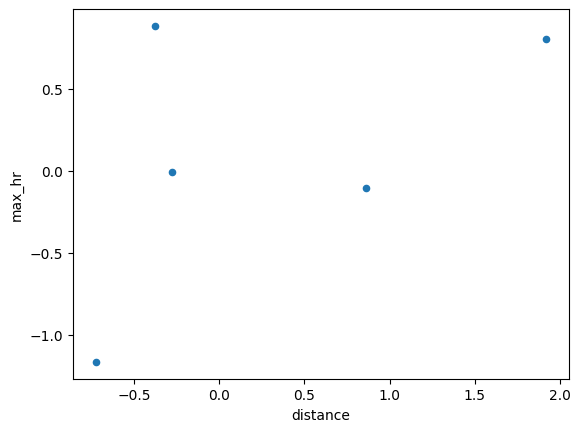

In [256]:
gmm_centroids[["distance", "max_hr"]].plot.scatter(x="distance", y="max_hr")

In [357]:
gmm_centroids.iloc[4,:]

distance   -0.375390
max_hr      0.884379
Name: 4, dtype: float64

In [36]:
cluster = gmm.predict(X[["distance", "duration", "max_hr"]])

<Axes: title={'center': 'LONG JOG'}, xlabel='type'>

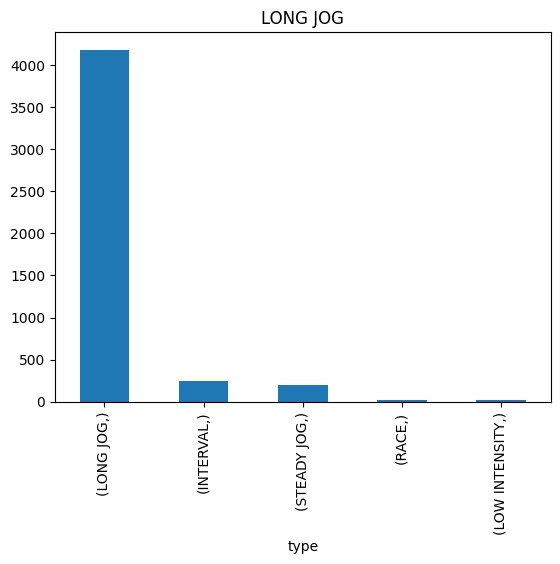

In [359]:
# LONG JOG cluster
y.loc[cluster==0].value_counts().plot(kind="bar", title="LONG JOG")

<Axes: title={'center': 'STEADY JOG'}, xlabel='type'>

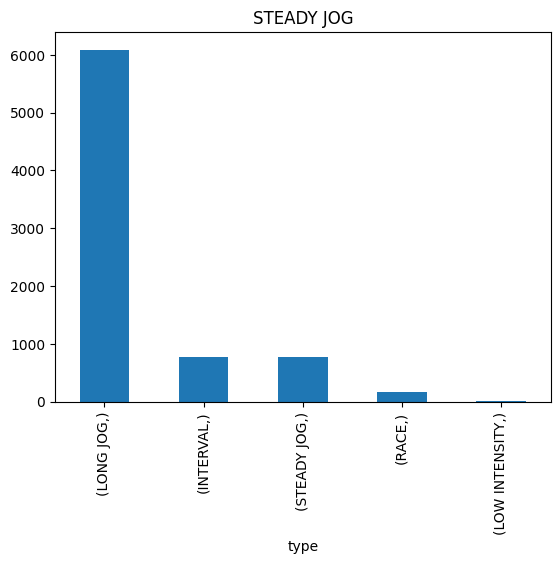

In [360]:
# STEADY JOG cluster
y.loc[cluster==1].value_counts().plot(kind="bar", title="STEADY JOG")

<Axes: title={'center': 'RACE'}, xlabel='type'>

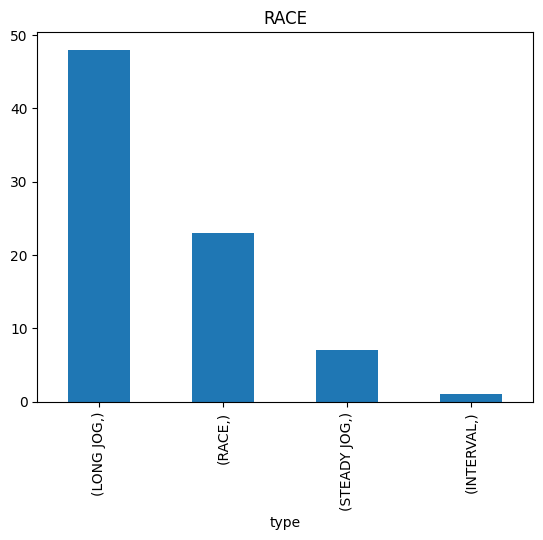

In [361]:
# RACE cluster
y.loc[cluster==2].value_counts().plot(kind="bar", title="RACE")

<Axes: title={'center': 'LOW INTENSITY'}, xlabel='type'>

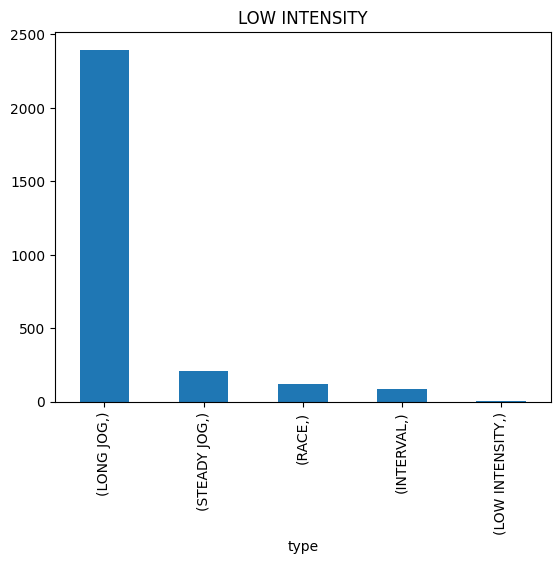

In [362]:
# LOW INTENSITY cluster
y.loc[cluster==3].value_counts().plot(kind="bar", title="LOW INTENSITY")

<Axes: title={'center': 'INTERVAL'}, xlabel='type'>

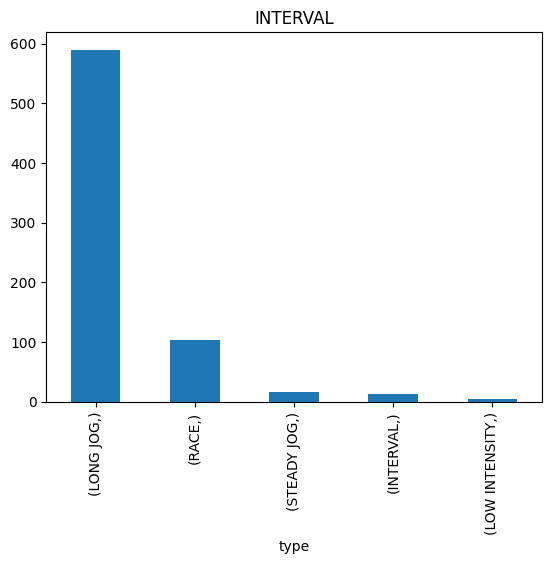

In [363]:
# INTERVAL cluster
y.loc[cluster==4].value_counts().plot(kind="bar", title="INTERVAL")

In [365]:
# create alternative ground truth

y_MANN = pd.DataFrame([np.nan]*len(X_train))
y_MANN.loc[cluster==0] = "LONG JOG"
y_MANN.loc[cluster==1] = "STEADY JOG"
y_MANN.loc[cluster==2] = "RACE"
y_MANN.loc[cluster==3] = "LOW INTENSITY"
y_MANN.loc[cluster==4] = "INTERVAL"

<Axes: title={'center': 'New Ground Truths'}, xlabel='0'>

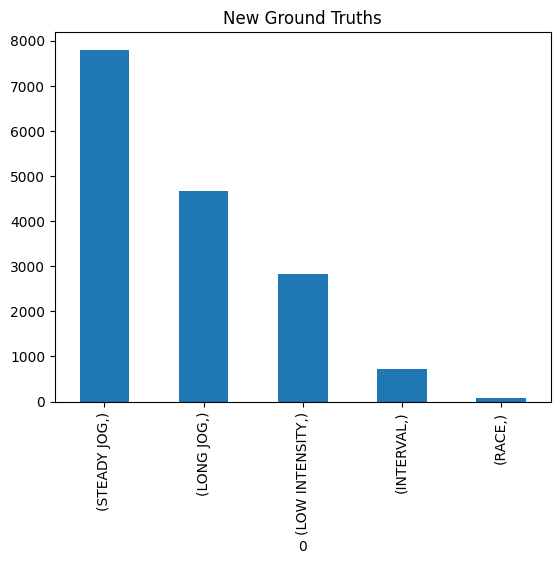

In [367]:
y_MANN.value_counts().plot(kind="bar", title="New Ground Truths")

In [ ]:
# classifier for alternative training type
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train[["distance", "duration", "max_hr"]], y_MANN)

#tree_params = {'max_depth': [3,5,10,15,20,50,90,120,150],
#               "min_samples_leaf": [1,3,5,10,30]}

#tree_cv = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5)
#tree_cv.fit(X[["distance", "duration", "max_hr"]], y_MANN)

For every runner, standardize distance, duration, & MaxHR and set alternative label

In [ ]:
runner_IDs = trainings["user_id"].unique().tolist()

for id in runner_IDs:
  X_runner = X_train.loc[train["user_id"]==id, ["distance", "duration", "max_hr"]]
  
  scaler = StandardScaler()
  scaler.fit_transform(X_runner)

  y_MANN.loc[(trainings["user_id"]==id).reset_index(drop=True)] = qda.predict(X_runner)[0]

<Axes: xlabel='0'>

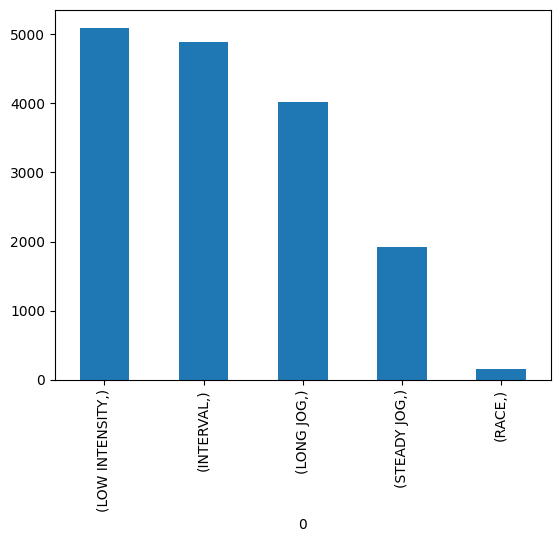

In [108]:
y_MANN.value_counts().plot(kind="bar")

In [ ]:
train["followed_recc"] = (1)*(y_MANN.values == y.values)

In [119]:
runners_mean = train.groupby(by="user_id").mean()

<ipython-input-119-dfe82bb88244>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  runners_mean = train.groupby(by="user_id").mean()


<Axes: >

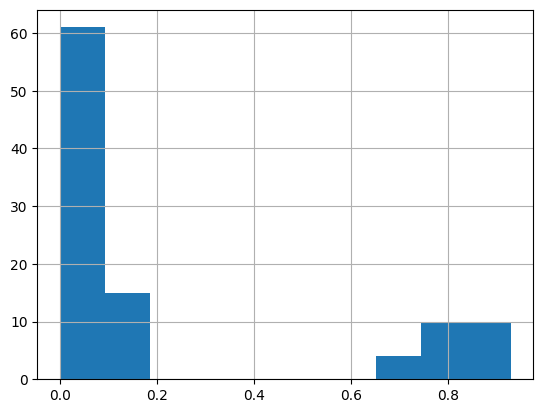

In [126]:
runners_mean["followed_recc"].hist()

In [127]:
runners_mean["followed_recc"].to_csv("follow_recc")